In [1]:
import sys
import numpy as np
from tqdm import tqdm_notebook
import pickle
import json as js
import pandas as pd
import plotly
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import time
import init_common as x
import init_spec_inout as xx
import simulate_corona_inout as sc
import multiprocessing as mp
from functools import partial
import helpers as hp
import calculate_healthcare_costs as htc

## setting
alpha_const = True
alpha_val0 = 1
alpha_val1 = 1
R0 = x.R0_default

Trec_const = False
beta_mixed = True

## setup
out_filename_dir,out_fig_dir,out_stat_dir=hp.setup_paths(R0,alpha_val0,"inout")
out_filename = out_filename_dir+"/"+x.out_filename
out_filename_info = out_filename_dir+"/info.json"
# choose distribution for beta and gammma

# alpha-strategy
if alpha_const:
    alpha_mat0 = np.full([x.N_locs,x.N_per],alpha_val0)
    alpha_mat1 = np.full([x.N_locs,x.N_per],alpha_val1)
else:
    idx_sel = np.arange(0,x.N_locs)
    tar_sel = 1
    per = 50
    init_rem = 1
    tar_rem = 1
    alpha_mat0 = hp.create_alpha_matrix(idx_sel,alpha_val0,tar_sel,per,init_rem,tar_rem)
    alpha_mat1 = np.full([x.N_locs,x.N_per],alpha_val1)

# get random vectors and rescale R0 if needed
R0_scale = R0/x.R0_default
beta_list,Tinf_list,beta0_list,beta1_list = xx.get_vectors(R0_scale)

## initialize
rep_vec = np.arange(0,x.N_simul)

def run_simulation(beta0_list,beta1_list,Tinf_list,alpha_mat0,alpha_mat1):
    fun = partial(sc.simul,beta0_list,beta1_list,Tinf_list,alpha_mat0,alpha_mat1)
    cores_cnt = mp.cpu_count()
    run_cnt = int(np.ceil(x.N_simul/cores_cnt))
    res = []
    dt_avg = 0
    for run_idx in np.arange(run_cnt):
        pool = mp.Pool(cores_cnt)
        tic = time.perf_counter()
        res0 = pool.map(fun,np.arange(0,cores_cnt))
        toc = time.perf_counter()
        pool.close()
        dt_avg += (toc-tic)
        res = res+res0
    dt_avg /= x.N_simul
    return res,dt_avg 

def save_results(filename,data,stat=False):
    if stat:       
        pct_S_mean = hp.mean_list(data,'sus')
        pct_I_mean = hp.mean_list(data,'inf')
        pct_R_mean = hp.mean_list(data,'rec')
        pct_S_q95 = hp.quant_list(data,'sus',.95)
        pct_I_q95 = hp.quant_list(data,'inf',.95)
        pct_R_q95 = hp.quant_list(data,'rec',.95)        
        pct_S_q05 = hp.quant_list(data,'sus',.05)
        pct_I_q05 = hp.quant_list(data,'inf',.05)
        pct_R_q05 = hp.quant_list(data,'rec',.05)
        data_stat = pd.DataFrame(list(zip(pct_S_mean, pct_I_mean, pct_R_mean, pct_S_q95,pct_I_q95,pct_R_q95,pct_S_q05,pct_I_q05,pct_R_q05)), 
                         columns = ['sus_mean','inf_mean','rec_mean','sus_q95','inf_q95','rec_q95','sus_q05','inf_q05','rec_05'])
        with open(filename+"_stat.pickle","wb") as fid_stat:
            pickle.dump(data_stat,fid_stat)
        fid_stat.close()
    with open(filename+".pickle",'wb') as fid:
        pickle.dump(data,fid)
    fid.close()
    dic = {"R0":R0,"alpha0":alpha_val0,"alpha1":alpha_val1,"Trec_const":Trec_const,"inout":True,"beta":beta_mixed}
    with open(out_filename_info,"w") as fid:
        js.dump(dic,fid)
    fid.close()
    
def export_res(data_arr,suf,name):
    opt = ["S","I","R"]
    for idx in opt:
        pd.DataFrame(sumlist(data_arr)[:,idx,:]).to_csv(name+".csv")


if alpha_const:
    print("Alpha0: "+str(np.round(alpha_val0,3)))
    print("Alpha1: "+str(np.round(alpha_val1,3)))
else:
    print("Alpha: plan")
print("R0:"+str(np.round(R0,3))+"\t (default value = "+str(np.round(x.R0_default,3))+")")
#print('R0 (responsible):',np.round(np.mean(beta_list0)*xx.Trec_mean,3))
#print('R0 (not responsible):',np.round(np.mean(beta_list1)*xx.Trec_mean,3))

print("Recovery Time constant: "+str(Trec_const))
print("Beta tail follows Power distribution: "+str(beta_mixed))

print("Running simulation ... ",end="",flush=True)
data,tpi=run_simulation(beta0_list,beta1_list,Tinf_list,alpha_mat0,alpha_mat1)
print("Finished")
print("Time per iteration (sec.): "+str(tpi))

## save results
print("Saving results ...",end="",flush=True)
save_results(out_filename,data,stat=False)
print("Finished")    
    

Alpha0: 1
Alpha1: 1
R0:1.48	 (default value = 1.48)
Recovery Time constant: False
Beta tail follows Power distribution: True
Running simulation ... Finished
Time per iteration (sec.): 4.950151843359374
Saving results ...Finished


Basic Statistics: number of observed infectious people, R0 = 1.48 Day 0 = 24.3.2020
Peak, mean value:  11202.0 ( 0.206 % of pop.)  day:  36
Peak, median value:  7004.0 ( 0.129 % of pop.)  day:  51
Peak, confidence interval at 95% :  37457.0 ( 0.688 % of pop.)  day:  36
Peak, confidence interval at 5% :  3297.0 ( 0.061 % of pop.)  day:  20


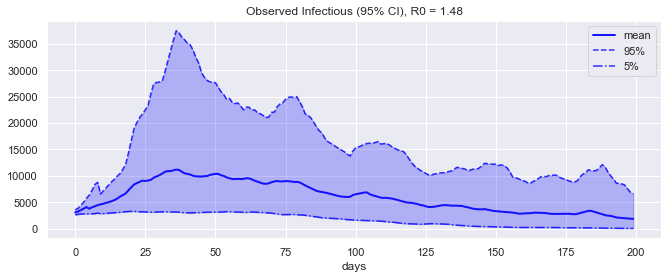

In [3]:
# Basic statistics
# 1. Peak of infectious, 95% CI
scaling_factor = 1#/x.first_infections_correction_multiplier
I_mean = hp.mean_list(data,'inf',ma=True,w=6)*scaling_factor
R_mean = hp.mean_list(data,'rec',ma=True,w=6)*scaling_factor
S_mean = hp.mean_list(data,'sus',ma=True,w=6)*scaling_factor
I_q95 = hp.quant_list(data,'inf',0.95,ma=True,w=10)*scaling_factor
I_q05 = hp.quant_list(data,'inf',0.05,ma=True,w=10)*scaling_factor
I_med = np.array(hp.quant_list(data,'inf',val=0.50,ma=True,w=10))*scaling_factor
I_mean_abs = np.round(x.N_popul_size*I_mean)
I_q95_abs = np.round(x.N_popul_size*I_q95)
I_q05_abs = np.round(x.N_popul_size*I_q05)
I_med_abs = np.round(x.N_popul_size*I_med)
print("Basic Statistics: number of observed infectious people, R0 = "+ str(np.round(R0,2)), 'Day 0 = 24.3.2020')
print('Peak, mean value: ',np.round(I_mean_abs.max()),'(',np.round(100*I_mean.max(),3),'% of pop.)', ' day: ',I_mean_abs.argmax())
print('Peak, median value: ',np.round(I_med_abs.max()),'(',np.round(100*I_med.max(),3),'% of pop.)',' day: ',I_med_abs.argmax())
print('Peak, confidence interval at 95% : ',np.round(I_q95_abs.max()),'(',np.round(100*I_q95.max(),3),'% of pop.)',' day: ',I_q95_abs.argmax())
print('Peak, confidence interval at 5% : ',np.round(I_q05_abs.max()),'(',np.round(100*I_q05.max(),3),'% of pop.)',' day: ',I_q05_abs.argmax())    

xval=np.arange(0,x.N_per)
plt.plot(xval,I_mean_abs,color='blue',linewidth=2,alpha=.9)
plt.plot(xval,I_q95_abs,color='blue',linestyle='--',alpha=.8)
plt.plot(xval,I_q05_abs,color='blue',linestyle='-.',alpha=.8)
plt.fill_between(xval,I_q05_abs,I_q95_abs,color='blue',alpha=0.25)
plt.legend(['mean', '95%', '5%'])
plt.xlabel("days")
plt.title("Observed Infectious (95% CI), R0 = "+ str(np.round(R0,2)))
plt.savefig(out_fig_dir+"/peaks.png",dpi=300)

with open('raw_data.pickle','wb') as f:
    pickle.dump(data,f)
        

In [ ]:
# 2. report changes in number of infected
def smooth(arr,w=8):
    arr =  pd.DataFrame(arr)
    arr = arr.apply(np.mean,1)
    xx = arr.rolling(window=w).mean()
    xx[0:w-1] = arr.rolling(window=2).mean()[0:w-1]
    arr[1:]=xx[1:]    
    return arr

def get_stat(data,colname,pop,fact):
    x_mean = pd.array(hp.mean_list(data,colname,ma=True,w=10))
    x_q95 = pd.array(hp.quant_list(data,colname,0.95,ma=True,w=10))
    x_q05 = pd.array(hp.quant_list(data,colname,0.05,ma=True,w=10))
    x_med = pd.array(np.array(hp.quant_list(data,colname,val=0.50,ma=True,w=10)))
    x_mean_abs = ((pop*x_mean)*fact)
    x_q95_abs = (pop*x_q95)*fact
    x_q05_abs = (pop*x_q05)*fact
    x_med_abs = (pop*x_med)*fact
    dx_mean_abs = smooth(x_mean_abs[1:x.N_per]-x_mean_abs[0:x.N_per-1])
    dx_q95_abs  = smooth(x_q95_abs[1:x.N_per]-x_q95_abs[0:x.N_per-1])
    dx_q05_abs  = smooth(x_q05_abs[1:x.N_per]-x_q05_abs[0:x.N_per-1])
    dx_mean_pct = smooth(100*(x_med_abs[1:x.N_per]/x_med_abs[0:x.N_per-1]-1))
    dx_q95_pct  = smooth(100*(x_q95_abs[1:x.N_per]/x_q95_abs[0:x.N_per-1]-1))
    dx_q05_pct  = smooth(100*(x_q05_abs[1:x.N_per]/x_q05_abs[0:x.N_per-1]-1))
    x_mean_abs = smooth(x_mean_abs)
    return x_mean_abs, x_med, x_q95_abs,x_q05_abs,dx_mean_abs,dx_q95_abs,dx_q05_abs

        
I_mean_abs,I_med,I_q95_abs,I_q05_abs,dI_mean_abs,dI_q95_abs,dI_q05_abs=get_stat(data,'inf',x.N_popul_size,scaling_factor)
S_mean_abs,S_med,S_q95_abs,S_q05_abs,dS_mean_abs,dS_q95_abs,dS_q05_abs=get_stat(data,'sus',x.N_popul_size,scaling_factor)
R_mean_abs,R_med,R_q95_abs,R_q05_abs,dR_mean_abs,dR_q95_abs,dR_q05_abs=get_stat(data,'rec',x.N_popul_size,scaling_factor)
I_in = -dS_mean_abs
I_out = dR_mean_abs

xval = np.arange(1,x.N_per)
plt.subplot(121)
plt.plot(xval,dI_mean_abs,color='blue',linewidth=2,alpha=.9)
plt.plot(xval,dI_q05_abs,color='blue',linestyle='--',alpha=.8)
plt.plot(xval,dI_q95_abs,color='blue',linestyle='-.',alpha=.8)
# plt.plot(xval,C_in,color='red',linewidth=2,alpha=.9)
plt.fill_between(xval,dI_q05_abs,dI_q95_abs,color='blue',alpha=0.25)
plt.title('Change in number of contagenous (daily basis, absolute numbers)')

I_in = np.round(-x.N_popul_size*np.array(hp.mean_diff_list(data,'sus'))/x.first_infections_correction_multiplier)
I_out = np.round(x.N_popul_size*np.array(hp.mean_diff_list(data,'rec'))/x.first_infections_correction_multiplier)
dI = np.round(x.N_popul_size*np.array(hp.mean_diff_list(data,'inf'))/x.first_infections_correction_multiplier)
xval = np.arange(1,x.N_per)

plt.subplot(122)
plt.plot(xval,I_in,color='blue',linewidth=2,alpha=.9)
plt.plot(xval,I_out,color='green',linewidth=2,alpha=.9)
plt.legend(['Newly Infectious','Newly Noncontageous'])
plt.title('Evolution of changes in flow of contagenous')

plt.savefig(out_fig_dir+"/change.png",dpi=300)

